# Spatial Lambda Fleming Viot process

## Generate Poisson dynamic $\Pi$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
import scipy.integrate as integr

In [331]:
class State:
    def __init__(self, time=0):
        self.time = 0
        self.individuals=None
        self.freeId = 1
    def update(self, individuals):
        Ids = np.arange(self.freeId, self.freeId+len(individuals))
        self.individuals = np.column_stack((Ids, individuals))
        self.freeId = self.freeId+len(individuals)
        
        
    def extinct(self, leftoversids):
        self.individuals = self.individuals[leftoversids]
    
    
    def recolonizate(self, individuals):
        Ids = np.arange(self.freeId, self.freeId+len(individuals))
        self.individuals = np.append(self.individuals, np.column_stack((Ids, individuals)),axis=0)
        self.freeId = self.freeId+len(individuals)
        
        
        

In [332]:
class Individual:
    def __init__(self, pos, genotype, epoch=0, parentId = None):
        self.id = 0
        self.parentId = parentId
        self.birthtime=epoch
        self.pos = pos
        self.genotype = genotype
        self.parent = None
        

In [425]:
class Model:
    def __init__(self, L, lamda, u0, rho, theta, alpha, n_alleles):
        self.rho=rho
        self.L=L
        self.u0=u0
        self.theta=theta
        self.alpha=alpha
        self.lamda = lamda
        self.state = State()
        self.n_alleles = n_alleles
        
        
    def generate_dynamic(self, n_epoch, time_init=0):
        '''Result is in (time, x, y)
        NOTE! MAYBE LAMDA SHOULD BE RENORMALISED'''
        times = time_init + np.cumsum(np.random.exponential(self.lamda, n_epoch))
        xs = np.random.uniform(0, self.L, n_epoch)
        ys = np.random.uniform(0, self.L, n_epoch)
        self.dynamic = np.column_stack((xs, ys, times))
        
        
    def generate_initial_points(self):
        N_points = np.random.poisson(self.rho*self.L**2)
        xs = np.random.uniform(0, self.L, N_points)
        ys = np.random.uniform(0, self.L, N_points)
        return np.column_stack((xs, ys))
        
        
    def generate_initial_points_with_alleles(self, proport=0.5):
        N_points = np.random.poisson(self.rho*self.L**2)
        xs = np.random.uniform(0, self.L, N_points)
        ys = np.random.uniform(0, self.L, N_points)
        alleles = np.random.choice([0, 1], (N_points, self.n_alleles), p = [1 - proport, proport])
        pId = np.full(N_points, 0)
        times = np.full(N_points, 0)
        self.state.update(np.column_stack((pId, times, xs, ys ,alleles)))
        
    
    def v(self, z, x):
        return np.exp(- np.linalg.norm(z-x)/(2 * self.alpha**2 * self.theta**2))
    
    
    def choose_parent(self, z):
        probs = []
        for x in self.state.individuals:
            probs.append(self.v(z[0:2], x[3:5]))
        return self.state.individuals[np.random.choice(np.arange(len(self.state.individuals)), p = probs/np.sum(probs))]
    
    
    def choose_parent_type(self, z):
        probs = []
        for x in self.state.individuals:
            probs.append(self.v(z[0:2], x[3:5])) 
        return self.state.individuals[np.random.choice(np.arange(len(self.state.individuals)), p = probs/np.sum(probs))][5:]
    
    
    def u(self, z, x):
        return self.u0 * np.exp(- np.linalg.norm(z-x)/(2 * self.theta**2))
    
    
    def extinction(self, z):
        indicies = []
        for i in range(len(self.state.individuals)):
            if np.random.uniform() >= self.u(z, self.state.individuals[i,3:5]):
                indicies.append(i)
                # print(f'{indicies=}')
        # print(f'survived {points[indicies].shape=}')
        self.state.extinct(indicies)
    
    
    def recolonization(self, z):
        parent = self.choose_parent(z)
        parentId = parent[0]
        parentType = parent[5:]
        intensity = lambda x, y: self.u(z, np.array([x,y]))
        max_intensity = intensity(z[0], z[1])
        total_intensity = integr.dblquad(intensity, 0, self.L, 0,  self.L )[0]
        # print(f"{total_intensity=}\n{max_intensity=}")
        n_points = np.random.poisson(self.rho * total_intensity) # Тут вроде total
        # print(f'{rho * total_intensity=}')
        # print(f'recolonized {n_points=}')
        points = []
        generated = 0
        while generated < n_points:
            x = np.random.uniform(0, self.L)
            y = np.random.uniform(0, self.L)

            if self.L**2 * intensity(x,y) >= np.random.uniform(0, max_intensity):
                points.append([x,y])
                generated += 1
        
        
        points = np.array(points,ndmin=2)
        points = np.column_stack(
            (
                np.full(n_points,parentId),
                np.full(n_points,0),
                points,
                np.full((n_points, self.n_alleles), parentType)
            )
        )
        self.state.recolonizate(points)
   

    
    
    
    def propagate(self, event):# parameters -- list [L, rho, u0, alpha, theta]
        z = event[0:2]
        self.extinction(z)
        self.recolonization(z)
    
    def run(self):
        for event in self.dynamic:
            self.propagate(event)
    
    
    def plot_with_alleles(self, allele=0, alpha=0.5):
        points = self.state.individuals
        plt.scatter(points[points[:,5+allele]==0][:,3],points[points[:,5+allele]==0][:,4], alpha, label ='0 allele')
        plt.scatter(points[points[:,5+allele]==1][:,3],points[points[:,5+allele]==1][:,4], alpha, label = '1 allele')
        plt.legend()
        plt.show();
        
        
    def plt_SFS1(self, z, beta=1):
        d = self.density(z, beta=1)
        N = 100
        y = []
        for i in range(N):
            y.append((d<(i+1)/100).sum())
        plt.plot(y)
        
    
    def plt_SFS2(self, z1, z2,beta=1):
        d1 = self.density(z1, beta=1)
        d2 = self.density(z2, beta=1)
        N = 100
        y = np.zeros((N,N))
        for i in range(N):
            for j in range(N):
                y[i,j]=(np.logical_and(d1<(i+1)/N, d2<(j+1)/N).sum())
        plt.imshow(y, extent=[0,1,0,1])
        
    
    def h(self, z, x, beta = 1):
        return np.exp(-np.linalg.norm(z-x)/beta**2)
    
    
    def density(self, z, beta=1):
        points = self.state.individuals
        denom = 0
        thetas = np.zeros(self.n_alleles)
        for x in points:
            denom += self.h(z, x[3:5], beta)
            for k in range(self.n_alleles):
                if x[k+5] == 1:
                    thetas[k] += self.h(z, x[3:5], beta)
        thetas = thetas / denom

        return thetas

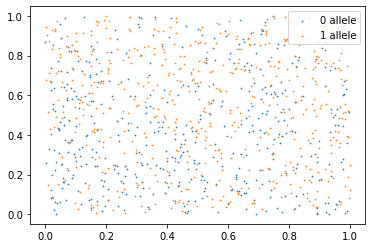

In [435]:
a.plot_with_alleles()

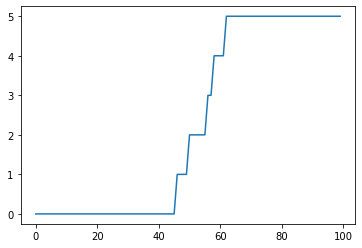

In [436]:
a.plt_SFS1(np.array([0.5, 0.5]))

In [428]:
a = Model(
    rho = 1000,
    L = 1,
    lamda = 1,
    u0 = 0.4,
    alpha = 1,
    theta = 0.2,
    n_alleles = 5
)

In [429]:
a.generate_dynamic(100)
a.generate_initial_points_with_alleles()

In [430]:
a.choose_parent(np.array([0.5,0.5]))

array([288.        ,   0.        ,   0.        ,   0.29380896,
         0.56424804,   0.        ,   1.        ,   0.        ,
         1.        ,   1.        ])

In [398]:
a.state.individuals.shape

(955, 10)

In [391]:
a.propagate(np.array([0.5,0.5, 12]))

In [433]:
a.run()

In [2]:
def generate_dynamic(n_epoch, lamda, L, time_init=0):
    '''Result is in (time, x, y)
    NOTE! MAYBE LAMDA SHOULD BE RENORMALISED'''
    times = time_init + np.cumsum(np.random.exponential(lamda, n_epoch))
    xs = np.random.uniform(0, L, n_epoch)
    ys = np.random.uniform(0, L, n_epoch)
    return np.column_stack((xs, ys, times))

## Generate inital points

In [3]:
def generate_initial_points(rho, L):
    N_points = np.random.poisson(rho*L**2)
    xs = np.random.uniform(0, L, N_points)
    ys = np.random.uniform(0, L, N_points)
    return np.column_stack((xs, ys))

In [4]:
def generate_initial_points_with_alleles(rho, L, proport, n_alleles=1):
    points = generate_initial_points(rho, L)
    size = len(points)
    alleles = np.random.choice([0, 1], (size, n_alleles), p = [1 - proport, proport])
    return np.column_stack((points[:,0],points[:,1] ,alleles))

In [5]:
def v(z, x, alpha, theta):
    return np.exp(- np.linalg.norm(z-x)/(2 * alpha**2 * theta**2))

In [6]:
def choose_parent(z, points, alpha, theta):
    probs = []
    for x in points[:,:2]:
        probs.append(v(z,x,alpha,theta)) 
    return points[np.random.choice(np.arange(len(points)), p = probs/np.sum(probs))]
        
        

In [7]:
def choose_parent_type(z, points, alpha, theta):
    probs = []
    for x in points[:,:2]:
        probs.append(v(z[0:2],x[0:2],alpha,theta)) 
    return points[np.random.choice(np.arange(len(points)), p = probs/np.sum(probs))][2:]

In [8]:
def u(z, x, theta, u0=0.5):
    return u0 * np.exp(- np.linalg.norm(z-x)/(2 * theta**2))

## Poisson density and rejection sampling

### 

In [9]:
def recolonization(L: float, u: callable, rho: float, z: float, theta: float, u0 = 1):
    intensity = lambda x, y: u(z, np.array([x,y]), theta, u0)
    max_intensity = intensity(z[0], z[1])
    total_intensity = integr.dblquad(intensity, 0, L, 0,  L )[0]
    # print(f"{total_intensity=}\n{max_intensity=}")
    n_points = np.random.poisson(rho * total_intensity) # Тут вроде total
    # print(f'{rho * total_intensity=}')
    # print(f'recolonized {n_points=}')
    points = []
    generated = 0
    while generated < n_points:
        x = np.random.uniform(0, L)
        y = np.random.uniform(0, L)

        if L**2 * intensity(x,y) >= np.random.uniform(0, max_intensity):
            points.append([x,y])
            generated += 1

    points = np.array(points,ndmin=2)
    # print(f'recolonized {points.shape=}')
    return(points)
    # plt.scatter(points[:,0], points[:,1])

In [10]:
def extinction(points, u: callable, z: float, theta: float, u0 = 1):
    indicies = []
    for i in range(len(points)):
        if np.random.uniform() >= u(z, points[i,:2], theta, u0):
            indicies.append(i)
            # print(f'{indicies=}')
    # print(f'survived {points[indicies].shape=}')
        
    return(points[indicies])

# One step propagete

In [18]:
def propagate(points_wa, event, parameters):# parameters -- list [L, rho, u0, alpha, theta]
    z = event[0:2]
    # print(z)
    L, rho, u0, alpha, theta = parameters
    points_after_extinction = extinction(points, u, z, theta, u0)
    parent_type = choose_parent_type(z, points, alpha, theta)
    new_points = recolonization(L, u, rho, z, theta, u0)
    new_points_wa = np.append(new_points, np.full((len(new_points),parent_type.shape[0]), parent_type), axis = 1)
    return np.concatenate((points_after_extinction, new_points_wa))
    

In [40]:
rho = 100000
L = 1
u0 = 0.1
alpha = 1
theta = 0.2
proport_init = 0.3

In [41]:
points = generate_initial_points_with_alleles(rho, L, proport_init, n_alleles=10)


In [22]:
new_points = propagate(points, np.array([0.5,0.5, 3]), [1, rho, u0, alpha, theta])
print(f'{new_points.shape=}')
print(f'{new_points[:,2].mean()=}')

new_points.shape=(1045, 12)
new_points[:,2].mean()=0.4784688995215311


In [52]:
def plot_with_alleles(points, allele=0, alpha=1):
    plt.scatter(points[points[:,2+allele]==0][:,0],points[points[:,2+allele]==0][:,1], alpha, label ='0 allele')
    plt.scatter(points[points[:,2+allele]==1][:,0],points[points[:,2+allele]==1][:,1], alpha, label = '1 allele')
    plt.legend()
    plt.show();

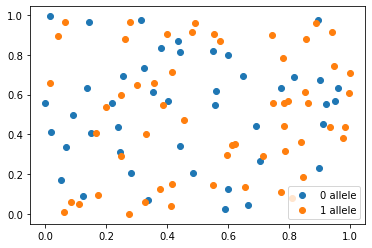

In [78]:
plot_with_alleles(points,3)

In [105]:
density(np.array([0.5,0.5]),points,h)

array([0.48840161, 0.50239002, 0.53801533, 0.55788838])

In [113]:
SFS1(np.array([0.5,0.5]),points,0.5,h)

1

In [28]:
def plt_SFS1(z, points,h,beta=2):
    d = density(z, points, h, beta=1)
    N = 100
    y = []
    for i in range(N):
        y.append((d<(i+1)/100).sum())
    plt.plot(y)

In [29]:
def plt_SFS2(z1, z2, points,h,beta=2):
    d1 = density(z1, points, h, beta=1)
    d2 = density(z2, points, h, beta=1)
    N = 100
    y = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            y[i,j]=(np.logical_and(d1<(i+1)/N, d2<(j+1)/N).sum())
    plt.imshow(y, extent=[0,1,0,1])

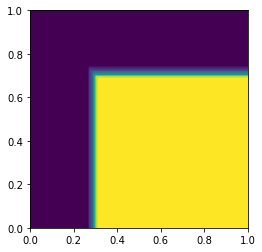

In [46]:
plt_SFS2(np.array([0.5,0.5]), np.array([0.1,0.9]),points,h)

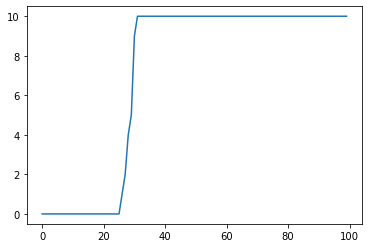

In [45]:
plt_SFS1(np.array([0.5,0.5]),points,h)

# Test with small number of individuals

In [39]:
rho = 100000
L = 1
u0 = 0.2
alpha = 1
theta = 0.01
proport_init = 0.5

In [223]:
points = generate_initial_points_with_alleles(rho, L, proport_init, 10)

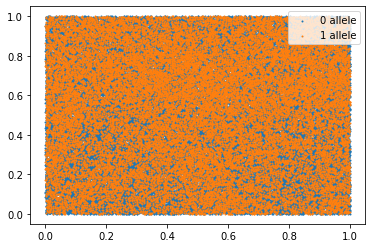

In [53]:
plot_with_alleles(points)

In [98]:
points.shape

(101, 6)

In [882]:
points[:,2].mean()

0.49692819015006545

In [44]:
freqs = []
for i in range(100):
    points = propagate(points, np.random.uniform(size=3), [1, rho, u0, alpha, theta])
    freqs.append(points[:,2].mean())
    # plot_with_alleles(points)

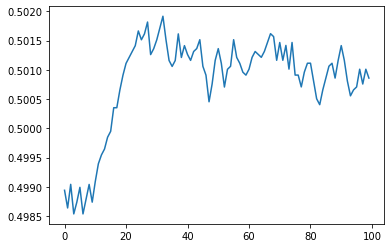

In [25]:
plt.plot(freqs)

In [28]:
points.shape[1]

3

In [32]:
ss1 = np.array([0.1, 0.2, 0.3, 0.4, 0.5])
ss2 = np.array([0.3, 0.4, 0.5, 0.6, 0.7])
np.logical_and(ss1<0.35, ss2<0.45).sum()

2

In [27]:
def h(z, x, beta = 1):
    return np.exp(-np.linalg.norm(z-x)/beta**2)

!TODO Сделать обработку событий когда или никого не убивают - создают, либо одного

In [31]:
def density(z, points, h, beta=1):
    denom = 0
    n_alleles = points.shape[1] - 2
    thetas = np.zeros(n_alleles)
    for x in points:
        denom += h(z, x[:2], beta)
        for k in range(n_alleles):
            if x[k+2] == 1:
                thetas[k] += h(z, x[:2], beta)
    thetas = thetas / denom
    
    return thetas
        
    

In [32]:
def SFS1(z, points, theta, h, beta=1):
    return (density(z, points, h, beta=1)<theta).sum()

In [33]:
def SFS2(z1, z2, points, theta1, theta2, h, beta=1):
    d1 = density(z1, points, h, beta=1)
    d2 = density(z2, points, h, beta=1)
    return np.logical_and(d1<theta1, d2<theta2).sum()

In [ ]:
dist_tor(x,y, L=1):
    retun min(
    np.norm(x - y))
    